## Importar librerias y modulos

In [19]:
import requests
import json
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Carga de datasets 
- Generacion
- Capacidad
- Demanda


In [20]:
df_generacion = pd.read_csv('../data/Generacion.csv')

#carga de dataset de demanda
dataset_id = '14fabb'              # Cambia este valor por el ID del dataset deseado
start_date = '2022-01-01'          # Fecha de inicio
end_date = '2025-11-05'            # Fecha de fin

df_demanda = descargar_datos_simem(dataset_id, start_date, end_date)
if df_demanda is not None:
    print(df_demanda.head())


  CodigoVariable            FechaHora CodigoSICAgente  TipoMercado Version  \
0        DdaReal  2025-08-30T23:00:00            HLAC  No Regulado     TXF   
1        DdaReal  2025-08-30T22:00:00            HLAC  No Regulado     TXF   
2        DdaReal  2025-08-30T21:00:00            HLAC  No Regulado     TXF   
3        DdaReal  2025-08-30T20:00:00            HLAC  No Regulado     TXF   
4        DdaReal  2025-08-30T19:00:00            HLAC  No Regulado     TXF   

      Valor UnidadMedida CodigoDuracion  
0  17229.27          kWh           PT1H  
1  17628.05          kWh           PT1H  
2  18293.14          kWh           PT1H  
3  19381.86          kWh           PT1H  
4  20091.45          kWh           PT1H  


## Visualzación de datos crudos

In [21]:
df_demanda

,CodigoVariable,FechaHora,CodigoSICAgente,TipoMercado,Version,Valor,UnidadMedida,CodigoDuracion
0,DdaReal,2025-08-30T23:00:00,HLAC,No Regulado,TXF,17229.27,kWh,PT1H
1,DdaReal,2025-08-30T22:00:00,HLAC,No Regulado,TXF,17628.05,kWh,PT1H
2,DdaReal,2025-08-30T21:00:00,HLAC,No Regulado,TXF,18293.14,kWh,PT1H
3,DdaReal,2025-08-30T20:00:00,HLAC,No Regulado,TXF,19381.86,kWh,PT1H
4,DdaReal,2025-08-30T19:00:00,HLAC,No Regulado,TXF,20091.45,kWh,PT1H
...,...,...,...,...,...,...,...,...
3349603,DdaReal,2025-01-24T04:00:00,PEEC,Regulado,TX4,2.76,kWh,PT1H
3349604,DdaReal,2025-01-24T03:00:00,PEEC,Regulado,TX4,2.69,kWh,PT1H
3349605,DdaReal,2025-01-24T02:00:00,PEEC,Regulado,TX4,2.67,kWh,PT1H
3349606,DdaReal,2025-01-24T01:00:00,PEEC,Regulado,TX4,2.67,kWh,PT1H


In [22]:
df_generacion

,Fecha,CodigoPlanta,TipoGeneracion,TipoClasificacion,TipoDespachoRecurso,GeneracionRealEstimada,GeneracionProgramadaDespacho,GeneracionProgramadaRedespacho
0,2019-12-30,2T4P,Hidraulica,Hidraulica,No Despachado Centralmente,301801.06,354240.00,354240.00
1,2019-12-30,TFL1,Termica,Termica,Despachado Centralmente,0.00,0.00,0.00
2,2019-12-30,MNT1,Hidraulica,Hidraulica,No Despachado Centralmente,41952.37,43200.00,43200.00
3,2019-12-30,VNTA,Hidraulica,Hidraulica,No Despachado Centralmente,54232.03,40560.00,40560.00
4,2019-12-30,2VJS,Solar,Solar,No Despachado Centralmente,44690.88,44690.88,44690.88
...,...,...,...,...,...,...,...,...
1091675,2018-09-22,PPA2,Termica,Termica,Despachado Centralmente,0.00,0.00,0.00
1091676,2018-09-22,2TYI,Termica,AUTOGENERADOR,No Despachado Centralmente,8916.00,8000.00,8000.00
1091677,2018-09-22,INZ1,Hidraulica,Hidraulica,No Despachado Centralmente,11586.31,12000.00,12000.00
1091678,2018-09-22,RMR1,Hidraulica,Hidraulica,No Despachado Centralmente,33636.83,47000.00,47000.00


## Columnas de interes:
- df_generacion: Fecha y GeneracionRealEstimada (kW)
- df_demanda: AnioEstudio, MesEstudio y DemandaSIN (kW)

In [23]:
df_generacion_fil = df_generacion[['Fecha', 'GeneracionRealEstimada']]
df_demanda_fil = df_demanda[['FechaHora','Valor']]


In [24]:
df_demanda_fil.head()

,FechaHora,Valor
0,2025-08-30T23:00:00,17229.27
1,2025-08-30T22:00:00,17628.05
2,2025-08-30T21:00:00,18293.14
3,2025-08-30T20:00:00,19381.86
4,2025-08-30T19:00:00,20091.45


In [25]:
df_generacion_fil.describe()

,GeneracionRealEstimada
count,1.091680e+06
mean,8.379024e+05
std,2.778703e+06
min,0.000000e+00
25%,1.420000e+03
50%,3.925703e+04
75%,3.098320e+05
max,2.997673e+07


# Funciones


Función para convertir de AAAA-MM-DD a AAAA-MM: 
- Se toman los valores de GeneracionRealEstimada diarios y se suman a un total mensual

In [26]:
# Función para totalizar los valores por día
def preparar_datos_diarios(df, fecha_col='Fecha', valor_col='GeneracionRealEstimada'):
    """
    Agrupa los datos por día y suma todos los valores de cada fecha.
    Si hay múltiples registros por día (por ejemplo, por hora), los totaliza.
    
    - df: DataFrame con columna de fecha y valores.
    - fecha_col: nombre de columna de fecha.
    - valor_col: nombre de columna con valores.
    
    Retorna un DataFrame con columnas: 'Fecha' (AAAA-MM-DD) y 'Valor' (suma diaria)
    """
    # Convertir columna de fecha a datetime
    df = df.copy()
    df[fecha_col] = pd.to_datetime(df[fecha_col])
    
    # Extraer solo la fecha (sin hora) para agrupar por día
    df['Fecha_Dia'] = df[fecha_col].dt.date
    
    # Agrupar por fecha y sumar todos los valores del mismo día
    resultado = df.groupby('Fecha_Dia')[valor_col].sum().reset_index()
    resultado.columns = ['Fecha', 'Valor']
    
    # Convertir de nuevo a datetime para mantener consistencia
    resultado['Fecha'] = pd.to_datetime(resultado['Fecha'])
    
    # Ordenar por fecha
    resultado = resultado.sort_values('Fecha').reset_index(drop=True)
    
    return resultado


# Función para normalizar los datos en formato Kw
def normalizar_a_gwh(df, valor_col='Valor'):
    df = df.copy()
    # Cambiar de MWh a GWh (dividir por 1000, no por 1e9)
    df['Valor_KWh'] = df[valor_col] / 1000  # O verificar unidades originales
    df = df[['Fecha', 'Valor_KWh']]
    return df

# función para descargar los datos por la API de SIMEM
def descargar_datos_simem(dataset_id, start_date, end_date):
    """
    Descarga y retorna un DataFrame con los datos del SiMEM según dataset_id y fechas.
    """
    url = (f"https://www.simem.co/backend-files/api/datos-publicos?"
           f"datasetId={dataset_id}&startDate={start_date}&endDate={end_date}")
    parameters = []
    buffer = ""
    # Solicitud POST con streaming
    with requests.post(url, json=parameters, stream=True) as response:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                buffer += chunk.decode('utf-8')
    try:
        data = json.loads(buffer)
        df = pd.DataFrame(data)
        return df
    except json.JSONDecodeError as e:
        print("Error al decodificar JSON:", e)
        return None

## Modelos de maching learning

In [27]:
# ========================= PREPARACIÓN DE DATOS =========================
def preparar_datos_ml_diario(df, col_fecha='Fecha', col_valor='Valor_GWh'):
    """
    Prepara el DataFrame con datos diarios para modelos de ML.
    Convierte fechas a números enteros consecutivos (días desde inicio).
    """
    df = df.copy()
    df[col_fecha] = pd.to_datetime(df[col_fecha])
    df = df.sort_values(col_fecha).reset_index(drop=True)
    
    # Días desde la primera fecha
    fecha_inicio = df[col_fecha].min()
    df['dias_desde_inicio'] = (df[col_fecha] - fecha_inicio).dt.days
    
    X = df[['dias_desde_inicio']].values
    y = df[col_valor].values
    return X, y, df, fecha_inicio

def preparar_datos_prophet_diario(df, col_fecha='Fecha', col_valor='Valor_GWh'):
    """
    Prepara el DataFrame para Prophet (requiere columnas 'ds' y 'y').
    """
    df = df.copy()
    df['ds'] = pd.to_datetime(df[col_fecha])
    df['y'] = df[col_valor]
    return df[['ds', 'y']]

# ========================= PREDICCIÓN HASTA 2030 =========================
def predecir_hasta_2030_diario(model, df_prep, fecha_inicio, tipo='ml'):
    """
    Extiende predicciones diarias hasta 2030-12-31.
    """
    ultima_fecha = pd.to_datetime(df_prep['Fecha'].max())
    fecha_final = pd.Timestamp('2030-12-31')
    
    # Generar fechas futuras diarias
    fechas_futuras = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), 
                                    end=fecha_final, freq='D')
    
    if tipo == 'ml':
        # Para RF y LR
        ultimo_dia = df_prep['dias_desde_inicio'].max()
        dias_futuros = np.arange(ultimo_dia + 1, 
                                 ultimo_dia + 1 + len(fechas_futuras)).reshape(-1, 1)
        predicciones = model.predict(dias_futuros)
    else:
        # Para Prophet
        future = pd.DataFrame({'ds': fechas_futuras})
        forecast = model.predict(future)
        predicciones = forecast['yhat'].values
    
    df_futuro = pd.DataFrame({
        'Fecha': fechas_futuras,
        'Prediccion_KWh': predicciones
    })
    return df_futuro

# ========================= FUNCIÓN PRINCIPAL =========================
def comparar_modelos_diarios(df, col_fecha='Fecha', col_valor='Valor_KWh'):
    """
    Entrena todos los modelos con datos diarios, los compara y retorna predicciones hasta 2030.
    """
    print("="*70)
    print("ENTRENAMIENTO DE MODELOS CON DATOS DIARIOS")
    print("="*70)
    
    print("\nPreparando datos...")
    X, y, df_prep, fecha_inicio = preparar_datos_ml_diario(df, col_fecha, col_valor)
    df_prophet = preparar_datos_prophet_diario(df, col_fecha, col_valor)
    
    print(f"Total de registros: {len(X)} días")
    print(f"Fecha inicio: {fecha_inicio.date()}")
    print(f"Fecha fin datos: {df_prep['Fecha'].max().date()}")
    
    # Dividir en train/test (últimos 90 días para test)
    dias_test = 90
    split = len(X) - dias_test
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    df_prophet_train = df_prophet.iloc[:split]
    
    print(f"\nDatos de entrenamiento: {len(X_train)} días")
    print(f"Datos de prueba: {len(X_test)} días")
    
    resultados = {}
    
    # Random Forest
    print("\n[1/3] Entrenando Random Forest...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    resultados['Random Forest'] = {
        'modelo': rf_model,
        'metricas': {
            'MAE': mean_absolute_error(y_test, rf_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
            'R2': r2_score(y_test, rf_pred)
        },
        'tipo': 'ml'
    }
    
    # Regresión Lineal
    print("[2/3] Entrenando Regresión Lineal...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    resultados['Regresion Lineal'] = {
        'modelo': lr_model,
        'metricas': {
            'MAE': mean_absolute_error(y_test, lr_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, lr_pred)),
            'R2': r2_score(y_test, lr_pred)
        },
        'tipo': 'ml'
    }
    
    # Prophet
    print("[3/3] Entrenando Prophet...")
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_mode='multiplicative'
    )
    prophet_model.fit(df_prophet_train)
    future_test = pd.DataFrame({'ds': df_prophet.iloc[split:]['ds']})
    prophet_forecast = prophet_model.predict(future_test)
    prophet_pred = prophet_forecast['yhat'].values
    resultados['Prophet'] = {
        'modelo': prophet_model,
        'metricas': {
            'MAE': mean_absolute_error(y_test, prophet_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, prophet_pred)),
            'R2': r2_score(y_test, prophet_pred)
        },
        'tipo': 'prophet'
    }
    
    # Mostrar resultados
    print("\n" + "="*70)
    print("RESULTADOS DE EVALUACIÓN (ÚLTIMOS 90 DÍAS)")
    print("="*70)
    for nombre, info in resultados.items():
        print(f"\n{nombre}:")
        for metrica, valor in info['metricas'].items():
            print(f"  {metrica}: {valor:.4f}")
    
    # Seleccionar mejor modelo (menor MAE)
    mejor_nombre = min(resultados, key=lambda x: resultados[x]['metricas']['MAE'])
    mejor_info = resultados[mejor_nombre]
    print(f"\n{'🏆'*35}")
    print(f"MEJOR MODELO: {mejor_nombre}")
    print(f"MAE: {mejor_info['metricas']['MAE']:.4f} KWh")
    print(f"RMSE: {mejor_info['metricas']['RMSE']:.4f} KWh")
    print(f"R²: {mejor_info['metricas']['R2']:.4f}")
    print(f"{'🏆'*35}")
    
    # Reentrenar con todos los datos y predecir hasta 2030
    print(f"\nReentrenando {mejor_nombre} con todos los datos...")
    if mejor_info['tipo'] == 'ml':
        if mejor_nombre == 'Random Forest':
            mejor_modelo_final = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15)
        else:
            mejor_modelo_final = LinearRegression()
        mejor_modelo_final.fit(X, y)
    else:
        mejor_modelo_final = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05,
            seasonality_mode='multiplicative'
        )
        mejor_modelo_final.fit(df_prophet)
    
    print("Generando predicciones hasta 2030-12-31...")
    df_predicciones = predecir_hasta_2030_diario(
        mejor_modelo_final, df_prep, fecha_inicio, mejor_info['tipo']
    )
    
    print(f"\nPredicciones generadas: {len(df_predicciones)} días")
    print("\nPrimeras 10 predicciones:")
    print(df_predicciones.head(10))
    print("\nÚltimas 10 predicciones (2030):")
    print(df_predicciones.tail(10))
    
    return mejor_nombre, mejor_modelo_final, df_predicciones, resultados

# ========================= USO =========================
# Para generación:
print("\n" + "█"*70)
print("MODELO PARA GENERACIÓN DE ENERGÍA")
print("█"*70)
mejor_gen, modelo_gen, pred_gen, res_gen = comparar_modelos_diarios(
    df_diario_generacion_gwh,
    col_fecha='Fecha',
    col_valor='Valor_KWh'
)

print("\n\n" + "█"*70)
print("MODELO PARA DEMANDA DE ENERGÍA")
print("█"*70)
# Para demanda:
'''mejor_dem, modelo_dem, pred_dem, res_dem = comparar_modelos_diarios(
    df_diario_demanda_gwh,
    col_fecha='Fecha',
    col_valor='Valor_KWh'
)

# Guardar predicciones en CSV
#pred_gen.to_csv('predicciones_generacion_2030.csv', index=False)
#pred_dem.to_csv('predicciones_demanda_2030.csv', index=False)

#print("\n✅ Predicciones guardadas en archivos CSV")

'''


██████████████████████████████████████████████████████████████████████
MODELO PARA GENERACIÓN DE ENERGÍA
██████████████████████████████████████████████████████████████████████
ENTRENAMIENTO DE MODELOS CON DATOS DIARIOS

Preparando datos...
Total de registros: 1382 días
Fecha inicio: 2022-01-01
Fecha fin datos: 2025-10-13

Datos de entrenamiento: 1292 días
Datos de prueba: 90 días

[1/3] Entrenando Random Forest...


12:24:49 - cmdstanpy - INFO - Chain [1] start processing


[2/3] Entrenando Regresión Lineal...
[3/3] Entrenando Prophet...


12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing



RESULTADOS DE EVALUACIÓN (ÚLTIMOS 90 DÍAS)

Random Forest:
  MAE: 11203.5524
  RMSE: 13745.9223
  R2: -0.0008

Regresion Lineal:
  MAE: 11268.0293
  RMSE: 13801.5825
  R2: -0.0090

Prophet:
  MAE: 5705.1695
  RMSE: 7804.7498
  R2: 0.6773

🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
MEJOR MODELO: Prophet
MAE: 5705.1695 KWh
RMSE: 7804.7498 KWh
R²: 0.6773
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

Reentrenando Prophet con todos los datos...
Generando predicciones hasta 2030-12-31...

Predicciones generadas: 1905 días

Primeras 10 predicciones:
       Fecha  Prediccion_KWh
0 2025-10-14   237620.141185
1 2025-10-15   238375.621619
2 2025-10-16   238178.855154
3 2025-10-17   238203.384856
4 2025-10-18   227065.686112
5 2025-10-19   206892.718830
6 2025-10-20   229042.143934
7 2025-10-21   236842.264948
8 2025-10-22   237706.532063
9 2025-10-23   237594.922372

Últimas 10 predicciones (2030):
          Fecha  Prediccion_KWh
1895 2030-12-22   219987.576851
1896 2030-12-23   242749.233513
1897 2030-12-24   

'mejor_dem, modelo_dem, pred_dem, res_dem = comparar_modelos_diarios(\n    df_diario_demanda_gwh,\n    col_fecha=\'Fecha\',\n    col_valor=\'Valor_KWh\'\n)\n\n# Guardar predicciones en CSV\n#pred_gen.to_csv(\'predicciones_generacion_2030.csv\', index=False)\n#pred_dem.to_csv(\'predicciones_demanda_2030.csv\', index=False)\n\n#print("\n✅ Predicciones guardadas en archivos CSV")\n\n'

## Visualización de modelos
- inicio de exploracion de datos


ANÁLISIS DE PREDICCIONES ENERGÉTICAS 2025-2030

Total de registros: 1905 días
Rango de fechas: 2025-10-14 a 2030-12-31

Primeras 5 filas:
       Fecha  Generacion_GWh  Demanda_GWh  Balance_GWh
0 2025-10-14      238.100730   230.672334     7.428396
1 2025-10-15      239.469049   231.997963     7.471086
2 2025-10-16      239.689460   232.211498     7.477962
3 2025-10-17      239.740964   232.261395     7.479569
4 2025-10-18      227.905889   220.795557     7.110332

ESTADÍSTICAS DESCRIPTIVAS

GENERACIÓN:
count    1905.000000
mean      243.443431
std        14.632304
min       191.169874
25%       236.246454
50%       246.132441
75%       254.198730
max       272.562278
Name: Generacion_GWh, dtype: float64

DEMANDA:
count    1905.000000
mean      235.848350
std        14.175798
min       185.205653
25%       228.875909
50%       238.453467
75%       246.268099
max       264.058732
Name: Demanda_GWh, dtype: float64

BALANCE:
count    1905.000000
mean        7.595081
std         0.456507
mi

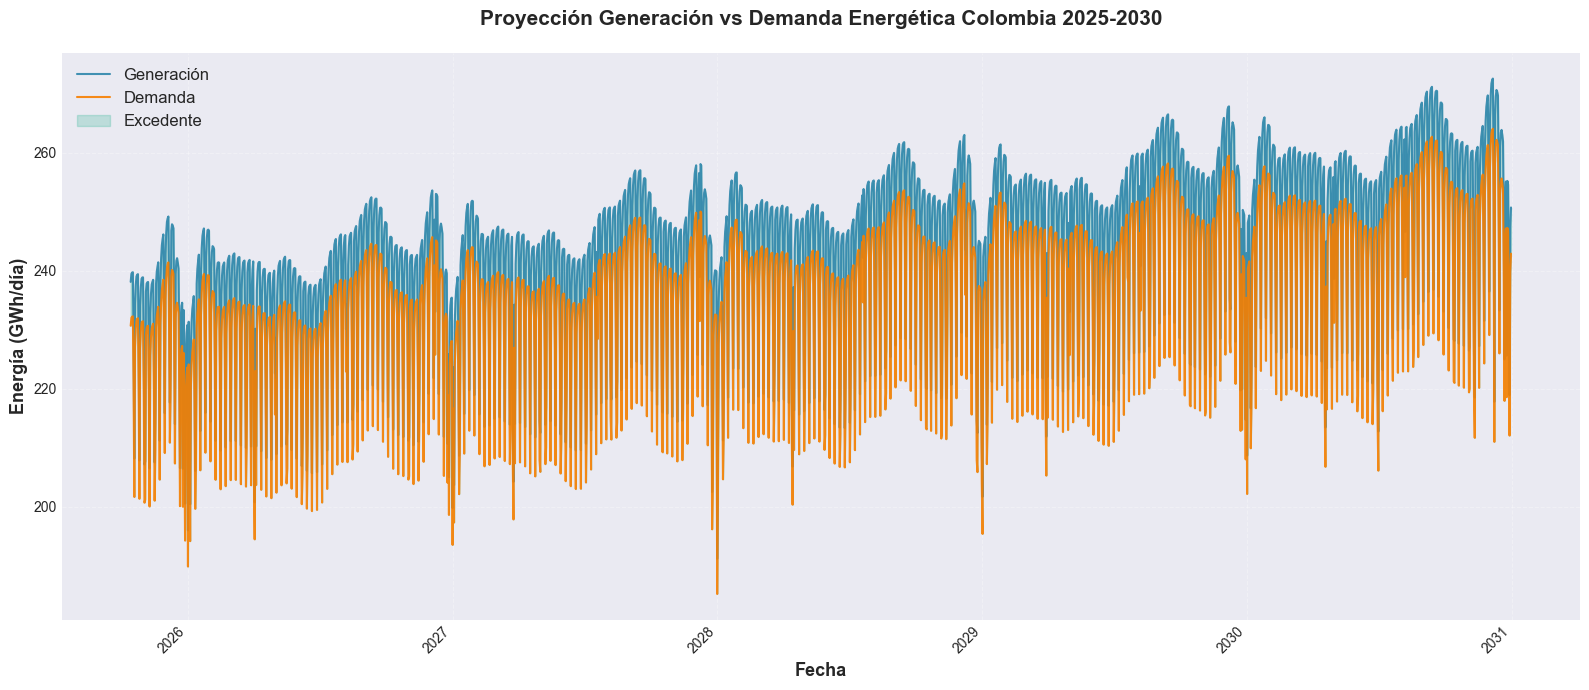


✓ Gráfica guardada: analisis_generacion_demanda.png


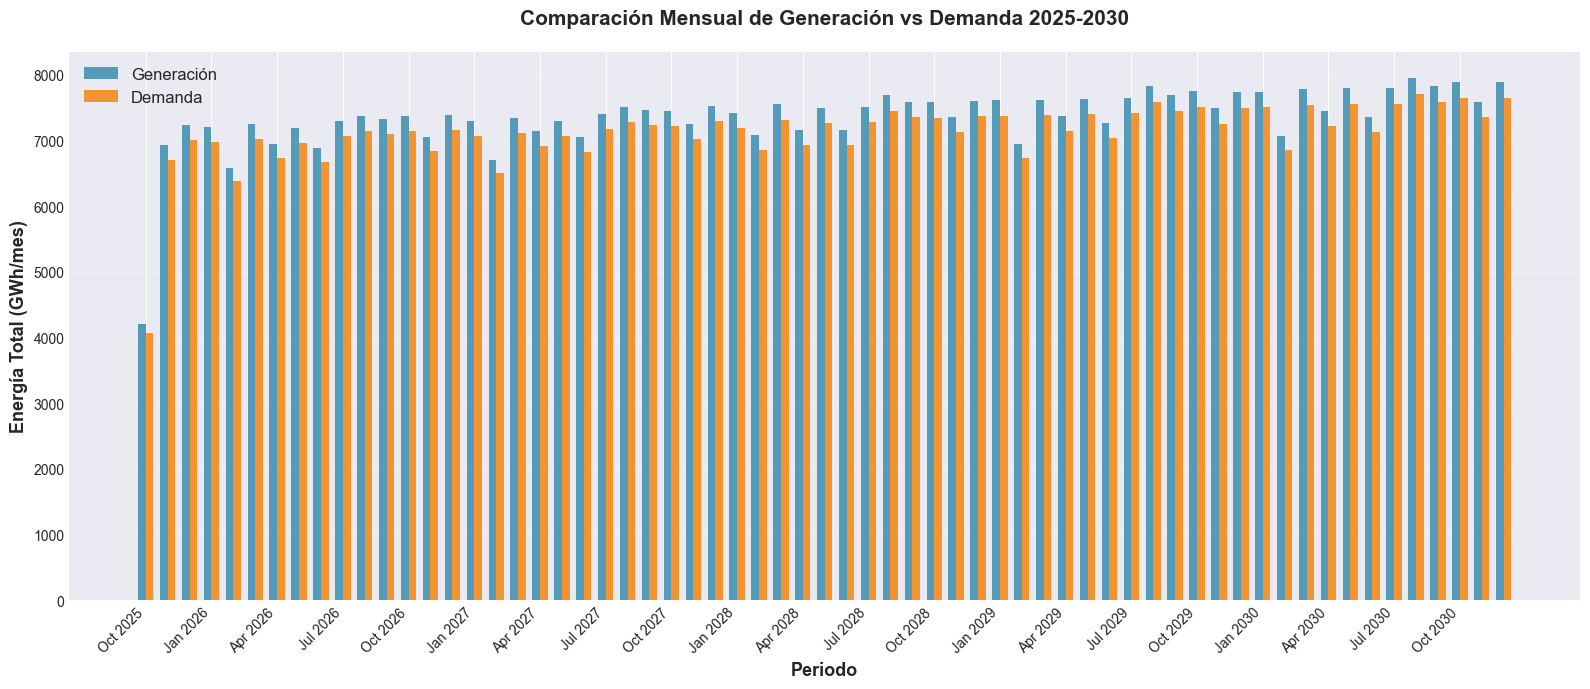

✓ Gráfica mensual guardada: analisis_mensual.png


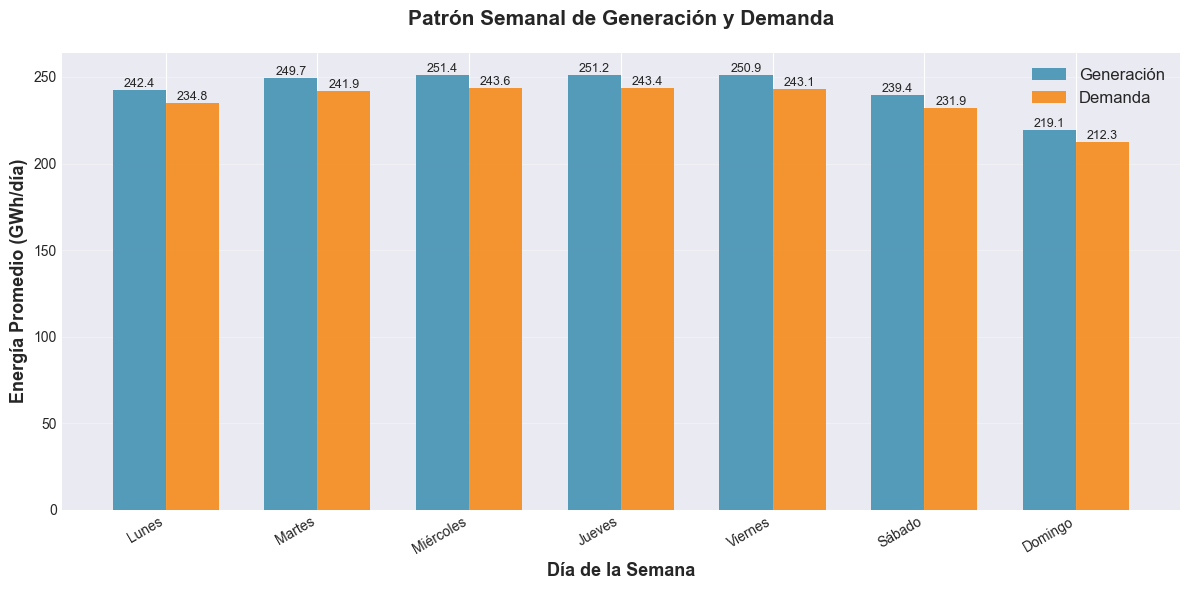

✓ Gráfica semanal guardada: patron_semanal.png


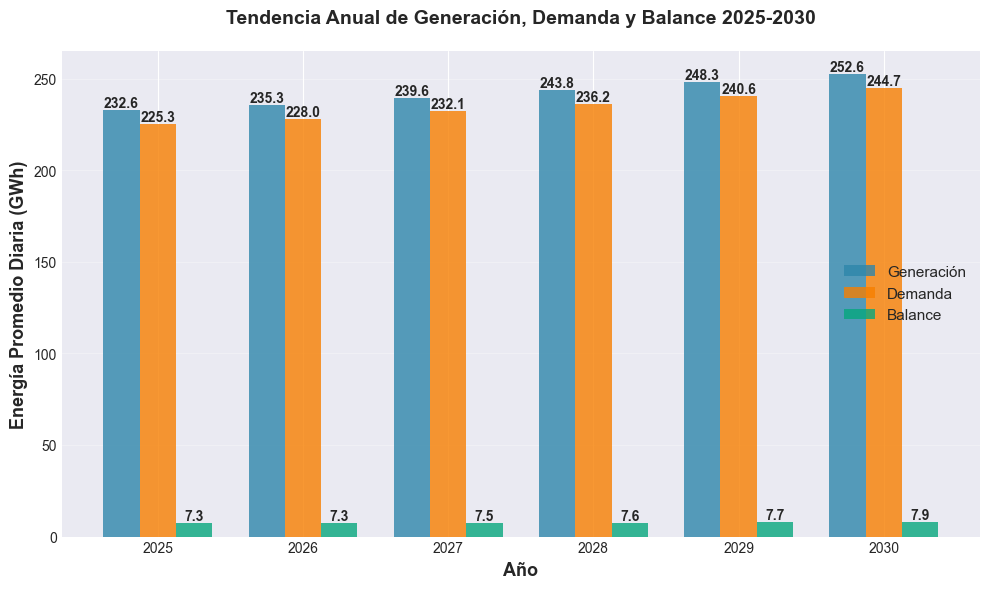

✓ Gráfica anual guardada: tendencia_anual.png

RESUMEN EJECUTIVO

..............................GENERACIÓN..............................
  Promedio 2025-2030: 243.44 GWh/día
  Mínimo: 191.17 GWh/día
  Máximo: 272.56 GWh/día
  Desviación estándar: 14.63 GWh

...............................DEMANDA................................
  Promedio 2025-2030: 235.85 GWh/día
  Mínimo: 185.21 GWh/día
  Máximo: 264.06 GWh/día
  Desviación estándar: 14.18 GWh

...............................BALANCE................................
  Excedente promedio: 7.60 GWh/día
  Excedente mínimo: 5.96 GWh/día
  Excedente máximo: 8.50 GWh/día

........................CRECIMIENTO 2025-2030.........................
  Generación: +8.58%
  Demanda: +8.58%

ANÁLISIS COMPLETADO

Archivos generados:
  ✓ analisis_generacion_demanda.png
  ✓ analisis_mensual.png
  ✓ patron_semanal.png
  ✓ tendencia_anual.png


In [28]:
"""
Análisis del comportamiento de Generación y Demanda 2025-2030
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# 1. CARGAR DATOS
# =============================================================================

df = pd.read_csv('predicciones_energia_2030_completo.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

print("="*70)
print("ANÁLISIS DE PREDICCIONES ENERGÉTICAS 2025-2030")
print("="*70)
print(f"\nTotal de registros: {len(df)} días")
print(f"Rango de fechas: {df['Fecha'].min().date()} a {df['Fecha'].max().date()}")
print(f"\nPrimeras 5 filas:")
print(df.head())

# =============================================================================
# 2. ESTADÍSTICAS DESCRIPTIVAS
# =============================================================================

print("\n" + "="*70)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*70)
print("\nGENERACIÓN:")
print(df['Generacion_GWh'].describe())
print("\nDEMANDA:")
print(df['Demanda_GWh'].describe())
print("\nBALANCE:")
print(df['Balance_GWh'].describe())

# =============================================================================
# 3. GRÁFICA PRINCIPAL: LÍNEAS DE TIEMPO
# =============================================================================

plt.style.use('seaborn-v0_8-darkgrid')  # Estilo profesional
fig, ax = plt.subplots(figsize=(16, 7))

# Graficar líneas
ax.plot(df['Fecha'], df['Generacion_GWh'], 
        label='Generación', color='#2E86AB', linewidth=1.5, alpha=0.9)
ax.plot(df['Fecha'], df['Demanda_GWh'], 
        label='Demanda', color='#F77F00', linewidth=1.5, alpha=0.9)

# Sombreado del excedente
ax.fill_between(df['Fecha'], df['Demanda_GWh'], df['Generacion_GWh'], 
                alpha=0.2, color='#06A77D', label='Excedente')

# Configuración
ax.set_xlabel('Fecha', fontsize=13, fontweight='bold')
ax.set_ylabel('Energía (GWh/día)', fontsize=13, fontweight='bold')
ax.set_title('Proyección Generación vs Demanda Energética Colombia 2025-2030', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Rotar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('analisis_generacion_demanda.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfica guardada: analisis_generacion_demanda.png")

# =============================================================================
# 4. GRÁFICA: COMPARACIÓN MENSUAL
# =============================================================================

# Agregar columnas de año y mes
df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month

# Agrupar por año y mes
df_mensual = df.groupby(['Año', 'Mes']).agg({
    'Generacion_GWh': 'sum',
    'Demanda_GWh': 'sum',
    'Balance_GWh': 'sum'
}).reset_index()

# Crear etiquetas de mes-año (CORREGIDO)
df_mensual['Periodo'] = pd.to_datetime(
    df_mensual[['Año', 'Mes']].rename(columns={'Año': 'year', 'Mes': 'month'}).assign(day=1)
)

fig, ax = plt.subplots(figsize=(16, 7))

# Barras agrupadas
x = np.arange(len(df_mensual))
width = 0.35

bars1 = ax.bar(x - width/2, df_mensual['Generacion_GWh'], width, 
               label='Generación', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, df_mensual['Demanda_GWh'], width, 
               label='Demanda', color='#F77F00', alpha=0.8)

# Configuración
ax.set_xlabel('Periodo', fontsize=13, fontweight='bold')
ax.set_ylabel('Energía Total (GWh/mes)', fontsize=13, fontweight='bold')
ax.set_title('Comparación Mensual de Generación vs Demanda 2025-2030', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x[::3])  # Mostrar cada 3 meses
ax.set_xticklabels(df_mensual['Periodo'].dt.strftime('%b %Y')[::3], rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_mensual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfica mensual guardada: analisis_mensual.png")


# =============================================================================
# 5. GRÁFICA: DISTRIBUCIÓN SEMANAL
# =============================================================================

# Agregar día de la semana
df['DiaSemana'] = df['Fecha'].dt.day_name()
df['DiaSemanaNum'] = df['Fecha'].dt.dayofweek

# Promedios por día de semana
df_semanal = df.groupby('DiaSemana').agg({
    'Generacion_GWh': 'mean',
    'Demanda_GWh': 'mean'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

dias_es = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(dias_es))
width = 0.35

bars1 = ax.bar(x - width/2, df_semanal['Generacion_GWh'], width, 
               label='Generación', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, df_semanal['Demanda_GWh'], width, 
               label='Demanda', color='#F77F00', alpha=0.8)

# Agregar valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Día de la Semana', fontsize=13, fontweight='bold')
ax.set_ylabel('Energía Promedio (GWh/día)', fontsize=13, fontweight='bold')
ax.set_title('Patrón Semanal de Generación y Demanda', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(dias_es, rotation=30, ha='right')
ax.legend(fontsize=12)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('patron_semanal.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfica semanal guardada: patron_semanal.png")

# =============================================================================
# 6. GRÁFICA: TENDENCIA ANUAL
# =============================================================================

df_anual = df.groupby('Año').agg({
    'Generacion_GWh': 'mean',
    'Demanda_GWh': 'mean',
    'Balance_GWh': 'mean'
}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

years = df_anual['Año']
x = np.arange(len(years))
width = 0.25

bars1 = ax.bar(x - width, df_anual['Generacion_GWh'], width, 
               label='Generación', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x, df_anual['Demanda_GWh'], width, 
               label='Demanda', color='#F77F00', alpha=0.8)
bars3 = ax.bar(x + width, df_anual['Balance_GWh'], width, 
               label='Balance', color='#06A77D', alpha=0.8)

# Valores en barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Año', fontsize=13, fontweight='bold')
ax.set_ylabel('Energía Promedio Diaria (GWh)', fontsize=13, fontweight='bold')
ax.set_title('Tendencia Anual de Generación, Demanda y Balance 2025-2030', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('tendencia_anual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfica anual guardada: tendencia_anual.png")

# =============================================================================
# 7. RESUMEN NUMÉRICO
# =============================================================================

print("\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)

print(f"\n{'GENERACIÓN':.^70}")
print(f"  Promedio 2025-2030: {df['Generacion_GWh'].mean():.2f} GWh/día")
print(f"  Mínimo: {df['Generacion_GWh'].min():.2f} GWh/día")
print(f"  Máximo: {df['Generacion_GWh'].max():.2f} GWh/día")
print(f"  Desviación estándar: {df['Generacion_GWh'].std():.2f} GWh")

print(f"\n{'DEMANDA':.^70}")
print(f"  Promedio 2025-2030: {df['Demanda_GWh'].mean():.2f} GWh/día")
print(f"  Mínimo: {df['Demanda_GWh'].min():.2f} GWh/día")
print(f"  Máximo: {df['Demanda_GWh'].max():.2f} GWh/día")
print(f"  Desviación estándar: {df['Demanda_GWh'].std():.2f} GWh")

print(f"\n{'BALANCE':.^70}")
print(f"  Excedente promedio: {df['Balance_GWh'].mean():.2f} GWh/día")
print(f"  Excedente mínimo: {df['Balance_GWh'].min():.2f} GWh/día")
print(f"  Excedente máximo: {df['Balance_GWh'].max():.2f} GWh/día")

# Crecimiento
crecimiento_gen = ((df[df['Año']==2030]['Generacion_GWh'].mean() / 
                    df[df['Año']==2025]['Generacion_GWh'].mean()) - 1) * 100
crecimiento_dem = ((df[df['Año']==2030]['Demanda_GWh'].mean() / 
                    df[df['Año']==2025]['Demanda_GWh'].mean()) - 1) * 100

print(f"\n{'CRECIMIENTO 2025-2030':.^70}")
print(f"  Generación: +{crecimiento_gen:.2f}%")
print(f"  Demanda: +{crecimiento_dem:.2f}%")

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO")
print("="*70)
print("\nArchivos generados:")
print("  ✓ analisis_generacion_demanda.png")
print("  ✓ analisis_mensual.png")
print("  ✓ patron_semanal.png")
print("  ✓ tendencia_anual.png")
